# Exploratory data analysis of the data from patient 11

---

In this notebook we will analyze PBMC data set from patient 11 obtained from blood samples taken at 3 different time points before, during and after the proton therapy treatment. The treatment takes approximately 6 weeks with multiple sessions.

The patient is 5 year old female that has an embryonal rhabdomyosarcoma. At each time point 3ml blood were taken and the PBMCs were purifried, stained with DAPI, gH2AX and Lamin A/C and imaged with 16bit at a resolution of 0.09 micron in x-y direction, respectively 0.5 micron in z-direction. Each FoV is of the size of (1024x1024x40) pixels.

The data will be compared with a control data set of PBMCs purified from blood of 10 healthy volunteers of varying sex and age (24-60). In this analyses we will use features extracted that describe the nuclear morphology and chromatin organization in 2D/3D and the gH2AX and Lamin A/C expression.

---

## 0. Environmental setup

First, we load the required libraries and define functions, that we will use later on for the analyses.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannot import add_stat_annotation

import sys
import cv2 as cv

seed = 1234
random.seed(1234)
np.random.seed(1234)

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def read_in_data(feature_file_path: str, qc_file_path: str, sample: str):
    features = pd.read_csv(feature_file_path, index_col=0)
    qc_results = pd.read_csv(qc_file_path, index_col=0)
    features.loc[qc_results.index, "qc_pass"] = qc_results.loc[
        qc_results.index, "qc_pass"
    ]
    features["sample"] = sample
    return features

<IPython.core.display.Javascript object>

In [3]:
def preprocess_data(
    data,
    drop_columns=[
        "label",
        "centroid-0",
        "centroid-1",
        "orientation",
        "weighted_centroid-0",
        "weighted_centroid-1",
    ],
):
    filtered_data = data.loc[data["qc_pass"] == True]
    print(
        "Nuclei that did not pass the quality check: {}/{}. Remaining: {}.".format(
            len(data) - len(filtered_data),
            len(data),
            len(filtered_data),
        )
    )
    data = filtered_data.loc[:, (filtered_data != filtered_data.iloc[0]).any()]
    data = data.dropna(axis=1)
    print(
        "Removed {} constant or features with missing values. Remaining: {}.".format(
            len(filtered_data.columns) - len(data.columns), len(data.columns)
        )
    )
    cleaned_data = data.drop(
        columns=list(set(drop_columns).intersection(set(data.columns)))
    )
    print(
        "Removed additional {} features. Remaining: {}.".format(
            len(data.columns) - len(cleaned_data.columns), len(cleaned_data.columns)
        )
    )
    return cleaned_data

<IPython.core.display.Javascript object>

In [4]:
def compute_vif(data):
    vifs = pd.DataFrame()
    vifs["feature"] = data.columns
    vifs["vif"] = [
        variance_inflation_factor(data.values, i) for i in range(data.shape[1])
    ]
    return vifs.sort_values("vif", ascending=False)

<IPython.core.display.Javascript object>

In [5]:
def remove_collinear_features(data, threshold=5):
    to_drop = []
    # Sequentially drop features with VIF > threshold
    vifs = compute_vif(data)
    print(vifs.head(5))
    while np.max(vifs.loc[:, "vif"]) > threshold:
        to_drop.append(vifs.loc[vifs["vif"] == np.max(vifs.loc[:, "vif"]), "feature"])
        vifs = compute_vif(data.drop(columns=[to_drop[-1]]))

    print(
        "Removed {}/{} features with a VIF above {}. Remaining: {}".format(
            len(to_drop),
            len(data.columns),
            threshold,
            len(data.columns) - len(to_drop),
        )
    )
    return data.drop(to_drop, axis=1)

<IPython.core.display.Javascript object>

In [6]:
def remove_correlated_features(data, threshold):
    data_corr = data.corr().abs()
    upper = data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(
        "Removed {}/{} features with a Pearson correlation above {}. Remaining: {}".format(
            len(to_drop),
            len(data.columns),
            threshold,
            len(data.columns) - len(to_drop),
        )
    )
    return data.drop(to_drop, axis=1)

<IPython.core.display.Javascript object>

In [7]:
def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    fi_df = fi_df.head(20)
    # Define size of bar plot
    plt.figure(figsize=(8, 6))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    # Add chart labels
    plt.title(model_type + "FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")
    plt.show()

<IPython.core.display.Javascript object>

In [8]:
def plot_roc_for_stratified_cv(X, y, n_splits, classifier, title, pos_label=None):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8, 8))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
            pos_label=pos_label,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=title)
    ax.legend(loc="lower right")
    return fig, ax, classifier

<IPython.core.display.Javascript object>

In [9]:
def compute_avg_conf_mtx(model, n_folds, features, labels):
    skf = StratifiedKFold(n_folds)
    features = np.array(features)
    labels = np.array(labels)
    n_classes = len(np.unique(labels))

    confusion_mtx = np.zeros([n_classes, n_classes])
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model.fit(X_train, y_train)
        confusion_mtx += confusion_matrix(
            y_test, model.predict(X_test), normalize="true"
        )
    confusion_mtx = confusion_mtx / n_folds
    return pd.DataFrame(
        confusion_mtx, index=sorted(set(labels)), columns=sorted(set(labels))
    )

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in the data sets that describe the PBMC population of the healthy controls as well as of patient 11 at the different time points over the course of the treatment.

In [10]:
hv_basedir = "../../../../../data/pbmc_hv/proteins/"
hv_subdirs = [f.path for f in os.scandir(hv_basedir) if f.is_dir()]
hv_datas = []
for hv_subdir in hv_subdirs:
    sample = os.path.split(hv_subdir)[1].split("_")[0].lower()
    hv_datas.append(
        read_in_data(
            feature_file_path=hv_subdir
            + "/preprocessed/full_pipeline/nuclear_features.csv",
            qc_file_path=hv_subdir
            + "/preprocessed/full_pipeline/segmentation/qc_results.csv",
            sample=sample,
        )
    )
hv_data = hv_datas[0].copy()
for i in range(1, len(hv_datas)):
    hv_data = hv_data.append(hv_datas[i])
hv_data["condition"] = "ctrl"

<IPython.core.display.Javascript object>

In [11]:
p11_1_basedir = "../../../../../data/pbmc_pt/proteins/timepoint_1/P11_1_PBMCs_Dapi_gH2AX_Lamin_28_07_21_2X_16bit_poly"
p11_1_data = read_in_data(
    feature_file_path=p11_1_basedir
    + "/preprocessed/full_pipeline/nuclear_features.csv",
    qc_file_path=p11_1_basedir
    + "/preprocessed/full_pipeline/segmentation/qc_results.csv",
    sample="p11_1",
)
p11_1_data["condition"] = "tp1"

<IPython.core.display.Javascript object>

In [12]:
p11_2_basedir = "../../../../../data/pbmc_pt/proteins/timepoint_2/P11_2_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_poly"
p11_2_data = read_in_data(
    feature_file_path=p11_2_basedir
    + "/preprocessed/full_pipeline/nuclear_features.csv",
    qc_file_path=p11_2_basedir
    + "/preprocessed/full_pipeline/segmentation/qc_results.csv",
    sample="p11_2",
)
p11_2_data["condition"] = "tp2"

<IPython.core.display.Javascript object>

In [13]:
p11_3_basedir = "../../../../../data/pbmc_pt/proteins/timepoint_3/P11_3_PBMCs_Dapi_gH2AX_Lamin_1_09_21_2X_16bit_poly"
p11_3_data = read_in_data(
    feature_file_path=p11_3_basedir
    + "/preprocessed/full_pipeline/nuclear_features.csv",
    qc_file_path=p11_3_basedir
    + "/preprocessed/full_pipeline/segmentation/qc_results.csv",
    sample="p11_3",
)
p11_3_data["condition"] = "tp3"

<IPython.core.display.Javascript object>

We will randomly subsample the data from each condition to the same sample size that is the minimum number of samples in any of the conditions.

In [14]:
np.random.seed(seed)
n_control_samples = np.min(
    [len(hv_data), len(p11_1_data), len(p11_2_data), len(p11_3_data)]
)
data = (
    hv_data.iloc[np.random.choice(len(hv_data), size=n_control_samples, replace=False)]
    .append(
        p11_1_data.iloc[
            np.random.choice(len(p11_1_data), size=n_control_samples, replace=False)
        ]
    )
    .append(
        p11_2_data.iloc[
            np.random.choice(len(p11_2_data), size=n_control_samples, replace=False)
        ]
    )
    .append(
        p11_3_data.iloc[
            np.random.choice(len(p11_3_data), size=n_control_samples, replace=False)
        ]
    )
)
data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,rel_lamin_3d_int,min_lamin_3d_int,max_lamin_3d_int,mean_lamin_3d_int,std_lamin_3d_int,q25_lamin_3d_int,q75_lamin_3d_int,median_lamin_3d_int,kurtosis_lamin_3d_int,skewness_lamin_3d_int
count,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,...,884.000000,884.0,884.000000,884.000000,884.000000,884.0,884.000000,884.000000,884.000000,884.000000
mean,3.897059,60.556561,79.926471,0.766757,23.095116,41.337981,33.600395,33.288176,23.184800,30.182346,...,1104.098926,0.0,13843.255656,1104.098926,1366.810779,0.0,179.459276,610.852941,62.860108,6.132420
std,2.777851,7.591658,10.694259,0.110435,5.734295,6.429113,3.245248,3.166369,5.834033,3.331118,...,2672.256082,0.0,12299.034683,2672.256082,2251.380198,0.0,531.793069,2038.409692,170.593433,2.517304
min,1.000000,24.000000,44.000000,0.314607,0.330982,26.381287,17.473910,16.826493,0.330982,13.311456,...,64.243603,0.0,4459.000000,64.243603,219.386111,0.0,14.000000,0.000000,3.596008,2.164751
25%,2.000000,56.000000,72.000000,0.703987,20.461323,36.710545,31.399014,31.116950,20.466422,28.168089,...,242.666443,0.0,7562.750000,242.666443,554.171728,0.0,67.000000,27.000000,36.236023,5.113149
50%,3.000000,61.000000,78.000000,0.786667,24.259306,40.116000,33.402908,33.030496,24.288731,30.322403,...,324.420694,0.0,9199.500000,324.420694,668.494558,0.0,82.000000,47.000000,51.293995,6.044796
75%,5.000000,66.000000,86.000000,0.848060,27.025366,45.000786,35.802936,35.459019,27.135906,32.396588,...,618.559496,0.0,13996.250000,618.559496,1089.084061,0.0,109.000000,98.000000,66.535566,6.813291
max,19.000000,77.000000,130.000000,0.956522,34.407164,94.642881,56.235780,55.673997,37.455585,37.653297,...,34327.142518,0.0,65535.000000,34327.142518,22434.417853,0.0,8796.000000,30148.000000,3538.996298,50.176261


<IPython.core.display.Javascript object>

---

## 2. Dimensionality reduction

Next, we will clean the data and remove samples with missing values, constant features, as well as those samples that were flagged for not passing our quality checks.

In [15]:
data = preprocess_data(data)

Nuclei that did not pass the quality check: 59/884. Remaining: 825.
Removed 11 constant or features with missing values. Remaining: 267.
Removed additional 6 features. Remaining: 261.


<IPython.core.display.Javascript object>

In [16]:
features = data.iloc[:, :-2]
sample_labels = data.loc[:, "sample"]
condition_labels = data.loc[:, "condition"]

<IPython.core.display.Javascript object>

Finally, we will reduce the dimensionality of the data set further by removing highly correlated features ($\rho > 0.8$).

In [17]:
# features = remove_collinear_features(features, threshold=5)
features = remove_correlated_features(features, threshold=0.8)

Removed 202/259 features with a Pearson correlation above 0.8. Remaining: 57


<IPython.core.display.Javascript object>

There are 57 features that remain which have a correlation of less than 0.8 to any other feature.

---

## 3. Data visualization

Next, we will visualize the data set using TSNE. To this end, we will first z-score the data.

In [18]:
features_sc = pd.DataFrame(
    StandardScaler().fit_transform(features),
    index=features.index,
    columns=features.columns,
)
features_sc.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,concavity,area_bbarea,std_curvature,npolarity_changes,max_posi_curv,...,q75_dna_3d_int,rel_gh2ax_2d_int,min_gh2ax_2d_int,max_gh2ax_2d_int,q25_gh2ax_2d_int,kurtosis_gh2ax_2d_int,q25_gh2ax_3d_int,q75_gh2ax_3d_int,rel_lamin_2d_int,kurtosis_lamin_2d_int
count,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,...,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02,8.250000e+02
mean,6.890111e-17,-1.722528e-16,1.894781e-16,-2.928297e-16,-6.890111e-17,-8.612639e-17,-1.980907e-15,-1.894781e-16,6.890111e-17,1.722528e-17,...,1.722528e-17,2.842171e-16,4.306320e-18,1.550275e-16,6.028847e-17,-1.399554e-16,-1.722528e-17,5.167584e-17,9.473903e-17,8.612639e-18
std,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,...,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00,1.000607e+00
min,-5.128059e+00,-2.829680e+00,-3.809173e+00,-4.129671e+00,-4.667737e+00,-1.012272e+00,-8.754775e+00,-2.250877e+00,-2.039656e+00,-1.368041e+00,...,-1.674041e+00,-1.329495e+00,-1.083648e+00,-2.427428e+00,-9.152002e-01,-1.009039e+00,-5.240116e-02,-1.202470e+00,-4.659644e-01,-3.767788e-01
25%,-6.921090e-01,-7.826547e-01,-5.647291e-01,-4.469748e-01,-7.138080e-01,-5.575798e-01,-3.611965e-01,-7.140209e-01,-6.292892e-01,-5.175249e-01,...,-6.185606e-01,-5.543976e-01,-4.368879e-01,-7.238672e-01,-9.152002e-01,-6.802999e-01,-5.240116e-02,-5.644479e-01,-3.503810e-01,-1.505005e-01
50%,1.008170e-03,-1.003131e-01,1.797387e-01,1.959519e-01,-8.253782e-02,-2.155903e-01,1.707952e-01,-2.565087e-02,-1.839101e-01,-3.204290e-01,...,-2.958029e-01,-2.154849e-01,-1.832782e-01,1.559478e-01,-3.745742e-02,-3.769353e-01,-5.240116e-02,-2.600208e-01,-2.998927e-01,-8.542645e-02
75%,6.941253e-01,5.820285e-01,7.524000e-01,6.803813e-01,7.251394e-01,2.530265e-01,6.207994e-01,5.991736e-01,4.841586e-01,1.681566e-01,...,2.618307e-01,3.626303e-01,1.556063e-01,1.051344e+00,7.038444e-01,3.740262e-01,-5.240116e-02,2.519831e-01,-1.390915e-01,-4.350654e-04
max,2.218983e+00,4.383646e+00,1.736053e+00,1.984978e+00,2.336663e+00,1.515943e+01,1.947948e+00,6.871999e+00,4.937950e+00,6.854208e+00,...,5.336948e+00,1.031050e+01,1.471214e+01,1.051344e+00,6.888622e+00,5.427015e+00,2.785121e+01,1.190800e+01,9.416166e+00,1.868131e+01


<IPython.core.display.Javascript object>

Next, we compute the TSNE.

In [19]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "condition"] = np.array(data.loc[tsne_embs.index, "condition"])

<IPython.core.display.Javascript object>

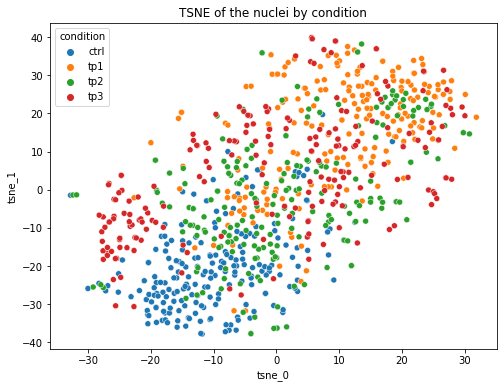

<IPython.core.display.Javascript object>

In [20]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=tsne_embs, x="tsne_0", y="tsne_1", hue="condition", ax=ax)
plt.title("TSNE of the nuclei by condition")
plt.show()

As you can see the blood cells before the first treatment are very different from those of the healthy control population. Interestingly the samples from the intermediate time point of the treament and the post-treatment time point are somewhat in the middle of the those two. This suggests that the treatment-induced reduction of the cancer signal is reflected in the state of the PBMCs. However, we see that the cells from the post-treatment time point are not necessarly closer clustering with the healthy population but seem to be well spread out in the whole space of the PBMCs. This could be for instance due to toxicity of the treatment.

---

## 4. Separability of the time points

Next, we will look more into the differences of the PBMC phenotypes at the different time points of the treatment in comparison to the healthy controls. To this end, we will train a RandomForest classifier model on distinguishing between the different data conditions.

To this end, we perform a 10-fold Stratified cross-validation approach and look at the average confusion matrix of the individual folds.

In [21]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)
avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc, n_folds=10, features=features_sc, labels=condition_labels
)

<IPython.core.display.Javascript object>

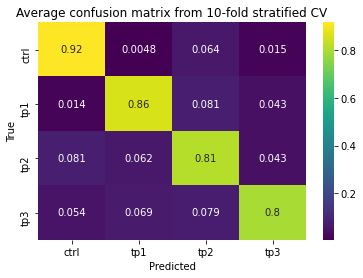

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.heatmap(avg_conf_mtx, annot=True, cmap="viridis", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Average confusion matrix from {}-fold stratified CV".format(10))
plt.show()

The confusion matrix further emphasizes the previous statements. We see that overall each time point is relatively distinct from the other and from the negative control. However, for the later time points (intermediate and post-treatment) the phenotypes of the models become more heterogenous some showing features more similar to the healthy control especially for the intermediate time point that is visible. Whereas, for the later we see a relative uniform distribution of the predicted classes for the missclassified samples.

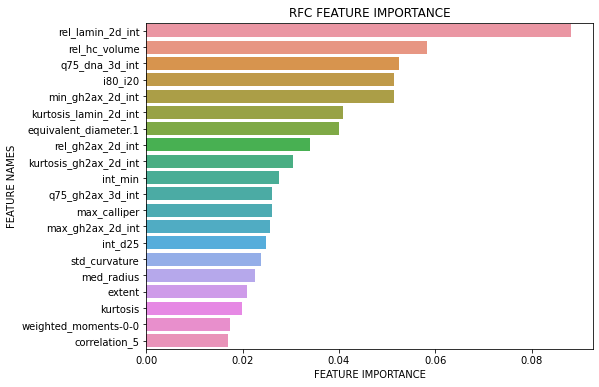

<IPython.core.display.Javascript object>

In [24]:
rfc = rfc.fit(features_sc, condition_labels)
plot_feature_importance(rfc.feature_importances_, features_sc.columns, "RFC ")

When we look at the features that got the highest importance we see that many of these are related to intensity features of the protein and 2D projected DAPI channel. Additionally some structural features like the equivalent diameter and the curvature are changing.

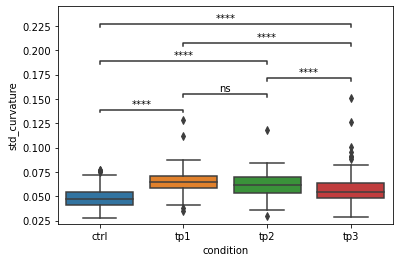

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.boxplot(data=data, x="condition", y="std_curvature", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="condition",
    y="std_curvature",
    box_pairs=[
        ("ctrl", "tp1"),
        ("ctrl", "tp2"),
        ("ctrl", "tp3"),
        ("tp1", "tp2"),
        ("tp1", "tp3"),
        ("tp2", "tp3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

In [26]:
list(data.columns)

['min_calliper',
 'max_calliper',
 'smallest_largest_calliper',
 'min_radius',
 'max_radius',
 'med_radius',
 'avg_radius',
 'mode_radius',
 'd25_radius',
 'd75_radius',
 'std_radius',
 'feret_max',
 'area',
 'perimeter',
 'bbox_area',
 'convex_area',
 'equivalent_diameter',
 'major_axis_length',
 'minor_axis_length',
 'eccentricity',
 'concavity',
 'solidity',
 'a_r',
 'shape_factor',
 'area_bbarea',
 'avg_curvature',
 'std_curvature',
 'npolarity_changes',
 'max_posi_curv',
 'avg_posi_curv',
 'med_posi_curv',
 'std_posi_curv',
 'sum_posi_curv',
 'len_posi_curv',
 'max_neg_curv',
 'avg_neg_curv',
 'med_neg_curv',
 'std_neg_curv',
 'sum_neg_curv',
 'len_neg_curv',
 'num_prominant_pos_curv',
 'prominance_prominant_pos_curv',
 'width_prominant_pos_curv',
 'prominant_pos_curv',
 'num_prominant_neg_curv',
 'prominance_prominant_neg_curv',
 'width_prominant_neg_curv',
 'prominant_neg_curv',
 'frac_peri_w_posi_curvature',
 'frac_peri_w_neg_curvature',
 'frac_peri_w_polarity_changes',
 'int_m

<IPython.core.display.Javascript object>

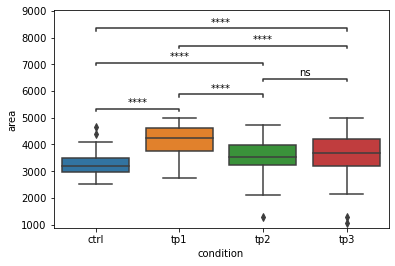

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.boxplot(data=data, x="condition", y="area", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="condition",
    y="area",
    box_pairs=[
        ("ctrl", "tp1"),
        ("ctrl", "tp2"),
        ("ctrl", "tp3"),
        ("tp1", "tp2"),
        ("tp1", "tp3"),
        ("tp2", "tp3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

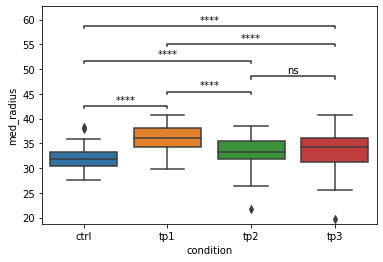

<IPython.core.display.Javascript object>

In [28]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.boxplot(data=data, x="condition", y="med_radius", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="condition",
    y="med_radius",
    box_pairs=[
        ("ctrl", "tp1"),
        ("ctrl", "tp2"),
        ("ctrl", "tp3"),
        ("tp1", "tp2"),
        ("tp1", "tp3"),
        ("tp2", "tp3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

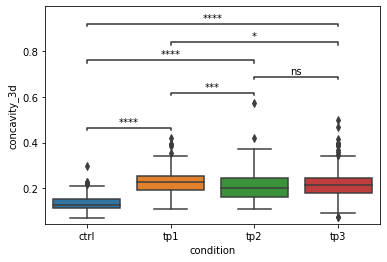

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.boxplot(data=data, x="condition", y="concavity_3d", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="condition",
    y="concavity_3d",
    box_pairs=[
        ("ctrl", "tp1"),
        ("ctrl", "tp2"),
        ("ctrl", "tp3"),
        ("tp1", "tp2"),
        ("tp1", "tp3"),
        ("tp2", "tp3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

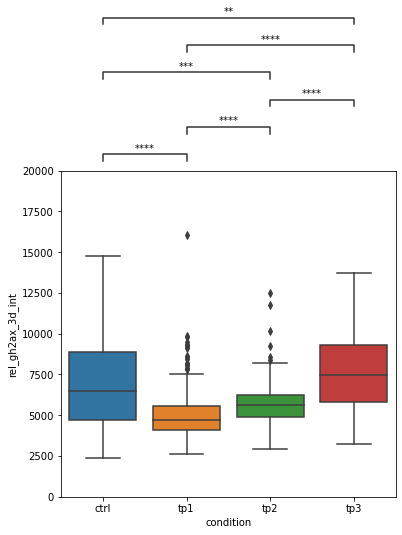

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots(figsize=[6, 6])
sns.boxplot(data=data, x="condition", y="rel_gh2ax_3d_int", ax=ax)
ax.set_ylim([0, 20000])
add_stat_annotation(
    ax,
    data=data,
    x="condition",
    y="rel_gh2ax_3d_int",
    box_pairs=[
        ("ctrl", "tp1"),
        ("ctrl", "tp2"),
        ("ctrl", "tp3"),
        ("tp1", "tp2"),
        ("tp1", "tp3"),
        ("tp2", "tp3"),
    ],
    test="Mann-Whitney",
    loc="outside",
    verbose=0,
)
plt.show()

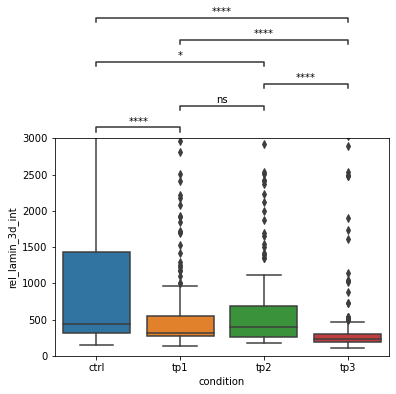

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.boxplot(data=data, x="condition", y="rel_lamin_3d_int", ax=ax)
ax.set_ylim([0, 3000])
add_stat_annotation(
    ax,
    data=data,
    x="condition",
    y="rel_lamin_3d_int",
    box_pairs=[
        ("ctrl", "tp1"),
        ("ctrl", "tp2"),
        ("ctrl", "tp3"),
        ("tp1", "tp2"),
        ("tp1", "tp3"),
        ("tp2", "tp3"),
    ],
    test="Mann-Whitney",
    loc="outside",
    verbose=0,
)
plt.show()